### Uploading a data set to IBM Cloud Object Storage 
You can either manually upload it using the IBM UI or through code ( [`CloudObjectStorage.ipynb`](https://github.com/yaghmo/Upload-anything-to-IBM-s-CloudObjectStorage/blob/main/Upload%20anything%20to%20IBM's%20CloudObjectStorage.ipynb))

### making a cos creds
Still explained on the ipynb file above, you cane select which role suits best. In my case i gave it a read only role so anyone can have a reading access only.

In [5]:
# read only creds #
cos_credentials = {
    "apikey": "r4hJR7nGlcqyQlOZD9tHONBndjkRWlTlAA_8PbvH-EKp",
    "cos_hmac_keys": {
        "access_key_id": "ea3874611e4143979087b2f404f96d05",
        "secret_access_key": "4e701d2029a17ed73e38f036aa2d3904db334a0c474a3952"
    },
    "endpoints": "https://control.cloud-object-storage.cloud.ibm.com/v2/endpoints",
    "iam_apikey_description": "Auto-generated for key crn:v1:bluemix:public:cloud-object-storage:global:a/a99fd3c7aa0b421aa3dde972740cf927:122c2661-6e6d-4514-9f3e-eab6c421d7c7:resource-key:ea387461-1e41-4397-9087-b2f404f96d05",
    "iam_apikey_name": "ReadOnly",
    "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Reader",
    "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/a99fd3c7aa0b421aa3dde972740cf927::serviceid:ServiceId-31f6232f-fe0d-4312-b870-d366d035ec79",
    "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/a99fd3c7aa0b421aa3dde972740cf927:122c2661-6e6d-4514-9f3e-eab6c421d7c7::"
}

In [6]:
# API access #
import ibm_boto3
from ibm_botocore.client import Config


auth_endpoint = 'https://iam.bluemix.net/oidc/token'
service_endpoint = 'https://s3.eu-de.cloud-object-storage.appdomain.cloud'

cos = ibm_boto3.client('s3',
                         ibm_api_key_id=cos_credentials['apikey'],
                        ibm_service_instance_id=cos_credentials['resource_instance_id'],
                         ibm_auth_endpoint=auth_endpoint,
                         config=Config(signature_version='oauth'),
                         endpoint_url=service_endpoint)

if cos:
    print("cnx Success")
else:
    print("burh")

cnx Success


In [7]:
# listing the buckets #
try:
    for bucket in cos.list_buckets()['Buckets']:
        print(bucket['Name'])
except:
    print("Connection failed / no bucket available")

26516166-f230-4e76-84ed-6832b71e21e8
jellyfish
jellyfishclassification-donotdelete-pr-e2swe7xtosto95
pythonbasicsfordatascienceproject-donotdelete-pr-tkd9hn4idb2h3n


In [8]:
# other buckets are kinda useless (~epmty) #
species = []
dirs = []
bucket_name = "jellyfish"
for obj in cos.list_objects(Bucket = bucket_name)['Contents']:
    if obj['Key'].split('/')[1] not in species:
        species.append(obj['Key'].split('/')[1])
    dirs.append(obj['Key'].split('/')[0])
print(len(cos.list_objects(Bucket ="jellyfish")['Contents'])-1,' files')
print(set(dirs),'with the spicies :',species)

978  files
{'valid', 'test', 'Train'} with the spicies : ['Moon_jellyfish', 'barrel_jellyfish', 'blue_jellyfish', 'compass_jellyfish', 'lions_mane_jellyfish', 'mauve_stinger_jellyfish']


In [10]:
# Load the sets #
from tqdm import tqdm
import numpy as np
from PIL import Image
import io

X_train, X_valid, X_test, y_train, y_valid, y_test = [],[],[],[],[],[]

for label, specie in tqdm(enumerate(species),total = len(species)):
    for obj in cos.list_objects(Bucket ="jellyfish",Prefix=list(set(dirs))[0]+'/'+specie)['Contents']:
        X_valid.append(np.array(Image.open(io.BytesIO(cos.get_object(Bucket ="jellyfish",Key=obj['Key']).get('Body').read()))))
        y_valid.append(label)
    for obj in cos.list_objects(Bucket ="jellyfish",Prefix=list(set(dirs))[1]+'/'+specie)['Contents']:
        X_test.append(np.array(Image.open(io.BytesIO(cos.get_object(Bucket ="jellyfish",Key=obj['Key']).get('Body').read()))))
        y_test.append(label)
    for obj in cos.list_objects(Bucket ="jellyfish",Prefix=list(set(dirs))[2]+'/'+specie)['Contents']:
        X_train.append(np.array(Image.open(io.BytesIO(cos.get_object(Bucket ="jellyfish",Key=obj['Key']).get('Body').read()))))
        y_train.append(label)

images = X_train + X_valid + X_test
labels = y_train + y_valid + y_test
print(set(x.shape for x in images))
print([x.shape for x in images].count(list(set(x.shape for x in images))[0]),'images \t',[x.shape for x in images].count(list(set(x.shape for x in images))[1]),'images')
print(set(x.dtype for x in images))

100%|██████████| 6/6 [00:57<00:00,  9.55s/it]

{(179, 179, 3), (224, 224, 3)}
268 images 	 711 images
{dtype('uint8')}


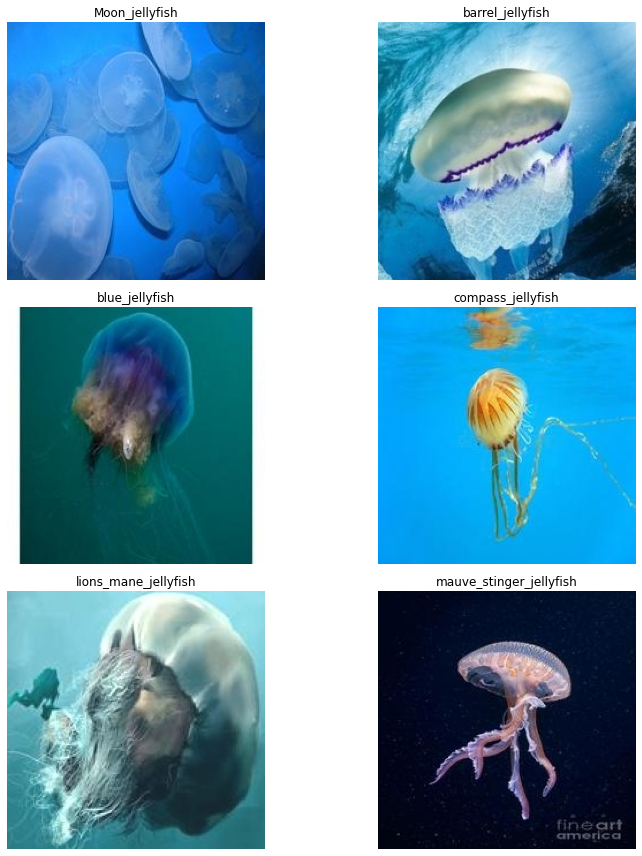

In [11]:
# sample image #
import matplotlib.pyplot as plt
import random


fig, axes = plt.subplots(3, 2, figsize=(12, 12))
for i, specie in enumerate(species):
    ix = random.randint(0, len(X_train)//len(set(specie)))
    key = cos.list_objects(Bucket ="jellyfish",Prefix='Train/'+specie)['Contents'][ix]['Key']
    image = cos.get_object(Bucket ="jellyfish",Key=key).get('Body').read()
    image = Image.open(io.BytesIO(image))
    row, col = i // 2, i % 2  
    ax = axes[row, col] 
    ax.imshow(np.array(image),axes=ax)
    ax.axis('off')
    ax.set_title(specie)
plt.tight_layout()
plt.show()

In [2]:
import tensorflow as tf
import sys
from keras.regularizers import l2
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, GlobalMaxPool2D, Flatten
from keras.utils import plot_model, to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


print("TensorFlow version:", tf.__version__)
print(f"\nPython {sys.version}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

TensorFlow version: 2.14.0

Python 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
GPU is available


In [4]:
# Configuring GPU #
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")  
    except RuntimeError as e:
        print(e)
else:
    strategy = tf.distribute.get_strategy()
    print('Number of replicas:', strategy.num_replicas_in_sync)

In [9]:
from sklearn.model_selection import train_test_split

im_height, im_width = 256, 256

# X_train_val, X_test, y_train_val, y_test = train_test_split(images, labels, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(images, labels, test_size=0.3, random_state=42)


def preprocess_image(image):
    image = tf.image.resize(image, (im_height, im_width))
    image = image / 255.0  
    return image

X_train = [preprocess_image(image) for image in X_train]
X_valid = [preprocess_image(image) for image in X_valid]
# X_test = [preprocess_image(image) for image in X_test]


X_train = np.array(X_train)
X_valid = np.array(X_valid)
# X_test = np.array(X_test)
y_train = np.array(y_train)
y_valid = np.array(y_valid)
# y_test = np.array(y_test)

num_classes = len(set(species))
y_train_cat = to_categorical(y_train, num_classes)
y_valid_cat = to_categorical(y_valid, num_classes)
# y_test_cat = to_categorical(y_test, num_classes)


train = tf.data.Dataset.from_tensor_slices((X_train, y_train_cat)).shuffle(buffer_size=len(X_train)).batch(16)
valid = tf.data.Dataset.from_tensor_slices((X_valid, y_valid_cat)).shuffle(buffer_size=len(X_valid)).batch(len(X_valid))
# test = tf.data.Dataset.from_tensor_slices((X_test, y_test_cat)).shuffle(buffer_size=len(X_test)).batch(len(X_test))


In [10]:
print('Training Dataset:', train)
# print('\nTesting Dataset:', test)
print('\nValidation Dataset:', valid)

Training Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>

Validation Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>


In [38]:
def get_cnn(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
        """Function to define the cnn Model"""

        x = Conv2D(n_filters * 2, (3, 3),strides = 1, activation='relu', padding='same')(input_img)#254
        if batchnorm:
                x = BatchNormalization()(x)        
        x = MaxPooling2D(pool_size = (2,2), padding = 'same')(x)#127
        x = Dropout(dropout*2)(x)

        x = Conv2D(n_filters * 4, (5, 5),strides = 1, kernel_regularizer=l2(0.1), activation='relu', padding='same')(x)#123
        if batchnorm:
                x = BatchNormalization()(x)    
        x = MaxPooling2D(pool_size = (2,2), padding = 'same')(x)#61
        x = Dropout(dropout*2)(x)

        x = Conv2D(n_filters * 8, (3, 3),strides = 1, kernel_regularizer=l2(0.1), activation='relu', padding='same')(x)#58
        if batchnorm:
                x = BatchNormalization()(x)    
        x = MaxPooling2D(pool_size = (2,2), padding = 'same')(x)#29
        x = Dropout(dropout*3)(x)

        x = Conv2D(n_filters * 16, (5, 5),strides = 1, kernel_regularizer=l2(0.1), activation='relu', padding='same')(x)#25
        if batchnorm:
                x = BatchNormalization()(x) 
        x = MaxPooling2D(pool_size = (2,2), padding = 'same')(x)#12
        x = Dropout(dropout*3)(x)

        x = Conv2D(n_filters * 32, (3, 3),strides = 1, activation='relu', padding='same')(x)#9
        if batchnorm:
                x = BatchNormalization()(x) 
        x = MaxPooling2D(pool_size = (2,2), padding = 'same')(x)#4
        x = Dropout(dropout*3)(x)

        x = Flatten()(x)
        x = Dense(2014,activation='relu')(x)#4 * 512
        x = Dropout(dropout*4)(x)

        x = Dense(1024,activation='relu')(x)
        # x = Dropout(dropout*4)(x)

        x = Dense(64,activation='relu')(x)
        # x = Dropout(dropout*2)(x)
        outputs = Dense((len(species)), activation = 'softmax')(x)

        model = Model(inputs=[input_img], outputs=[outputs])
        return model

In [39]:
from keras.layers import Input
from keras.optimizers import Adam, SGD, Adagrad
tf.keras.backend.clear_session()

input_img = Input((im_height, im_width,3))
with strategy.scope():
    model = get_cnn(input_img, n_filters=4, dropout=0.1, batchnorm=True)
model.compile(optimizer = SGD(learning_rate=0.001,momentum=0.02),
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy']) 

In [40]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 8)       224       
                                                                 
 batch_normalization (Batch  (None, 256, 256, 8)       32        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 8)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 128, 8)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      3216  

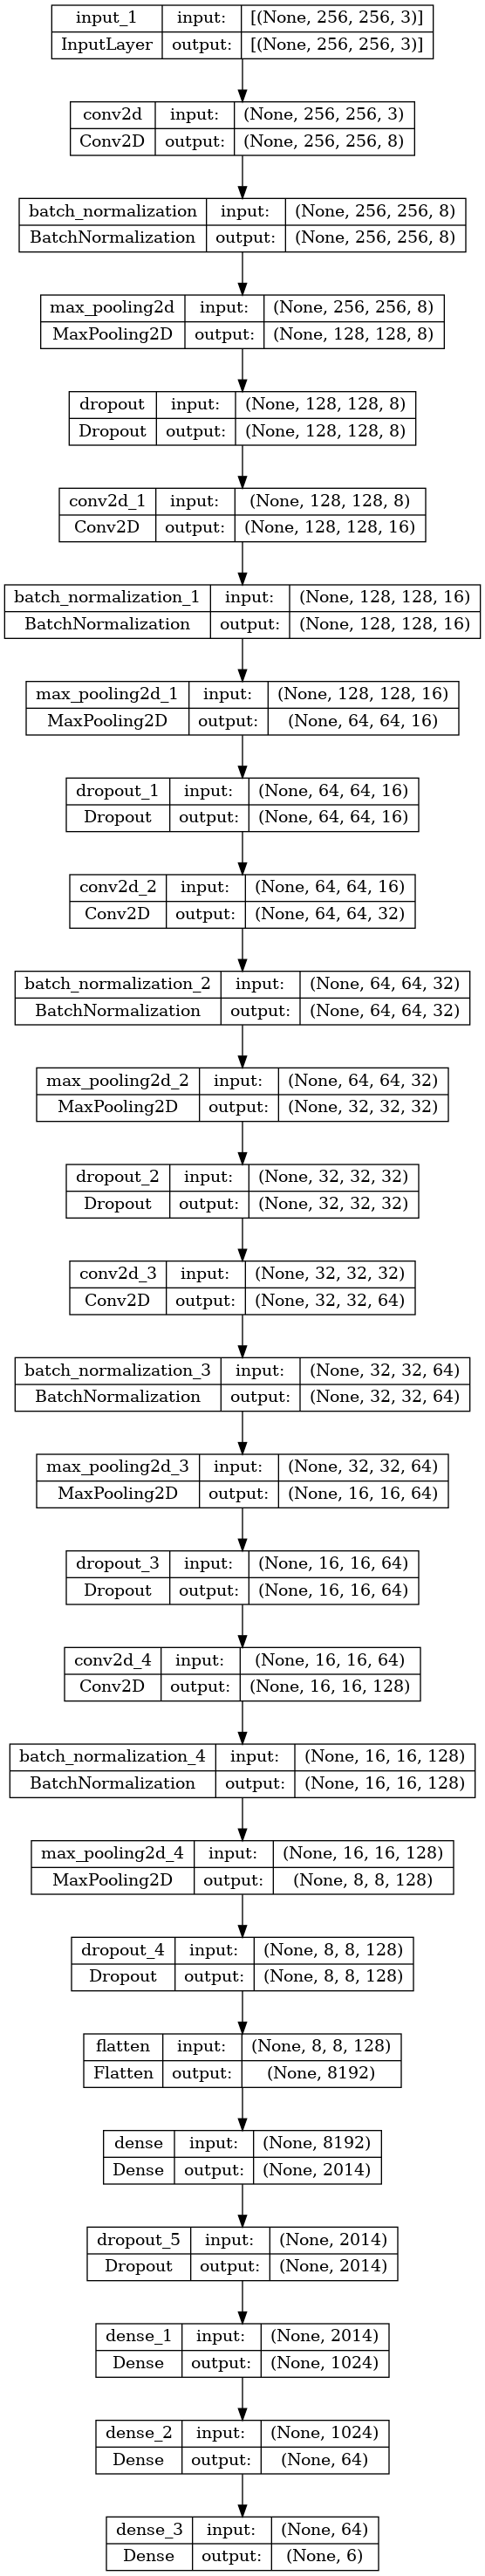

In [41]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [33]:
callbacks = [
    EarlyStopping(monitor = 'val_accuracy',patience = 20, mode = 'max', restore_best_weights = True),
    ReduceLROnPlateau(factor=0.2, patience=20, min_lr=0.00001),
    ModelCheckpoint('model-CNN.h5', mode='max', monitor='val_accuracy', save_best_only=True, save_weights_only=False)
]

In [ ]:
results = model.fit(train, epochs=200, callbacks=callbacks, validation_data=valid)

In [ ]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs_model = range(1, len(acc)+1) 

fig, axes = plt.subplots(1, 2,  figsize=(10,5))
axes[0].plot(epochs_model, acc, 'b', label = 'Training acc')
axes[0].plot(epochs_model, val_acc, 'orange', label = 'Validation acc')
axes[0].set_title('Training and validation accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='best')

axes[1].plot(epochs_model, loss, 'r', label = 'Training loss')
axes[1].plot(epochs_model, val_loss, 'g', label = 'Validation loss')
axes[1].set_title('Training and validation loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='best')
plt.show()


In [19]:
model.load_weights('model-CNN.h5')
model.compile(loss='binary_crossentropy', metrics=['accuracy'])
preds = model.predict(X_valid)  # Running model on the validation dataset


10/10 [==============================] - 2s 58ms/step


In [ ]:
tp = 0
for i, pred in enumerate(preds):
    if np.argmax(preds[i]) == np.argmax(y_valid_cat[i]):
        tp+=1
print('acc:',tp/len(preds))